# LA geography and demographics exploration

This notebook demonstrates how to load and visualize LA geography layers with Census demographics. All geographic data is in `data/standard/` with corresponding `*_demographics.parquet` files for layers with Census data.

See `config/layers.yml` for the complete list of available layers and their ID/name fields.

In [1]:
from pathlib import Path

import pandas as pd
import geopandas as gpd

from chorokit import plot_choropleth, LegendConfig, LayoutConfig

# Display options
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [2]:
# Paths
DATA_DIR = Path('../data/standard')
OUT_DIR = Path('../notebooks/outputs')
OUT_DIR.mkdir(exist_ok=True)

## Load layer with demographics

All polygon layers have demographics apportioned from 2020 Census blocks. Load the geography from the `.geojson` file and demographics from the matching `*_demographics.parquet` file, then join them on the layer's ID field.


In [3]:
# Example 1: LA City neighborhoods (LA Times boundaries)
layer_name = 'la_city_neighborhoods'

boundaries = gpd.read_file(DATA_DIR / f'{layer_name}.geojson')
demographics = pd.read_parquet(DATA_DIR / f'{layer_name}_demographics.parquet')

print(f"Loaded {len(boundaries):,} features")
print(f"CRS: {boundaries.crs}")

Loaded 114 features
CRS: EPSG:4326


In [4]:
# Quick preview of what columns are in the data
print("Boundary columns:", list(boundaries.columns))
print("\nDemographics columns:", list(demographics.columns)[:10], "...")

Boundary columns: ['objectid', 'name', 'area_sqmi', 'source_url', 'fetched_at', 'geometry']

Demographics columns: ['objectid', 'pop_total', 'pop_hispanic', 'pop_not_hispanic', 'pop_white_nh', 'pop_black_nh', 'pop_aian_nh', 'pop_asian_nh', 'pop_nhpi_nh', 'pop_other_nh'] ...


In [5]:
# Preview demographics data
demographics.head(3)

,objectid,pop_total,pop_hispanic,pop_not_hispanic,pop_white_nh,pop_black_nh,pop_aian_nh,pop_asian_nh,pop_nhpi_nh,pop_other_nh,pop_two_or_more_nh,housing_total,housing_occupied,housing_vacant,statefp20,countyfp20,tractce20,blockce20,geoid20,name20,mtfcc20,ur20,uace20,uatype20,funcstat20,aland20,awater20,intptlat20,intptlon20,housing20,pop20,P2_001N,fetched_at_1,census_vintage,name,fetched_at_2,source_blocks_count,apportioned_at,source_layer
0,1,16942.0,11714.0,5228.0,980.0,2671.0,19.0,972.0,7.0,116.0,463.0,5782.0,5511.0,271.0,06,037,222200,1001,060372222001001,Block 1001,G5040,U,51445,U,S,20349,0,+34.0318239,-118.2975280,30,129,129.0,2025-10-25T09:18:00.849624,2020,Adams-Normandie,2025-10-19 14:59:55.866,106,2025-11-16T11:46:12.051782,la_city_neighborhoods
1,2,32803.0,26014.0,6789.0,2610.0,277.0,50.0,3374.0,26.0,125.0,327.0,7860.0,7724.0,136.0,06,037,119202,3015,060371192023015,Block 3015,G5040,U,51445,U,S,22419,0,+34.2550439,-118.4390741,24,121,121.0,2025-10-25T09:18:00.849624,2020,Arleta,2025-10-19 14:59:55.866,246,2025-11-16T11:46:12.051782,la_city_neighborhoods
2,3,20116.0,11656.0,8460.0,1397.0,2625.0,33.0,3708.0,11.0,157.0,530.0,7480.0,7050.0,430.0,06,037,212900,2002,060372129002002,Block 2002,G5040,U,51445,U,S,57727,0,+34.0494421,-118.3222099,351,813,813.0,2025-10-25T09:18:00.849624,2020,Arlington Heights,2025-10-19 14:59:55.866,115,2025-11-16T11:46:12.051782,la_city_neighborhoods


In [6]:
# Available demographic columns
print("Population columns:")
pop_cols = [c for c in demographics.columns if c.startswith('pop_')]
for col in pop_cols:
    print(f"  {col}")

print("\nHousing columns:")
housing_cols = [c for c in demographics.columns if c.startswith('housing_')]
for col in housing_cols:
    print(f"  {col}")

Population columns:
  pop_total
  pop_hispanic
  pop_not_hispanic
  pop_white_nh
  pop_black_nh
  pop_aian_nh
  pop_asian_nh
  pop_nhpi_nh
  pop_other_nh
  pop_two_or_more_nh

Housing columns:
  housing_total
  housing_occupied
  housing_vacant


In [7]:
# Join on ID field (varies by layer - see config/layers.yml)
# For la_city_neighborhoods, the ID field is 'objectid'
joined = boundaries.merge(demographics, on='objectid', how='left')

print(f"Joined: {len(joined):,} features")
print(f"Columns: {len(joined.columns)}")

Joined: 114 features
Columns: 44


## Calculate percentages

Demographics are stored as raw counts. Calculate percentages for mapping.


In [8]:
# Calculate race/ethnicity percentages
joined['pct_hispanic'] = (joined['pop_hispanic'] / joined['pop_total'] * 100).round(1)
joined['pct_white_nh'] = (joined['pop_white_nh'] / joined['pop_total'] * 100).round(1)
joined['pct_black_nh'] = (joined['pop_black_nh'] / joined['pop_total'] * 100).round(1)
joined['pct_asian_nh'] = (joined['pop_asian_nh'] / joined['pop_total'] * 100).round(1)

# Show summary stats
print("Percent non-Hispanic Asian by neighborhood:")
print(f"  Min: {joined['pct_asian_nh'].min():.1f}%")
print(f"  Max: {joined['pct_asian_nh'].max():.1f}%")
print(f"  Mean: {joined['pct_asian_nh'].mean():.1f}%")

Percent non-Hispanic Asian by neighborhood:
  Min: 0.3%
  Max: 44.9%
  Mean: 11.6%


## Map 1: Asian population by LA City neighborhood

Production-quality choropleth using chorokit with proper legend, title and source.


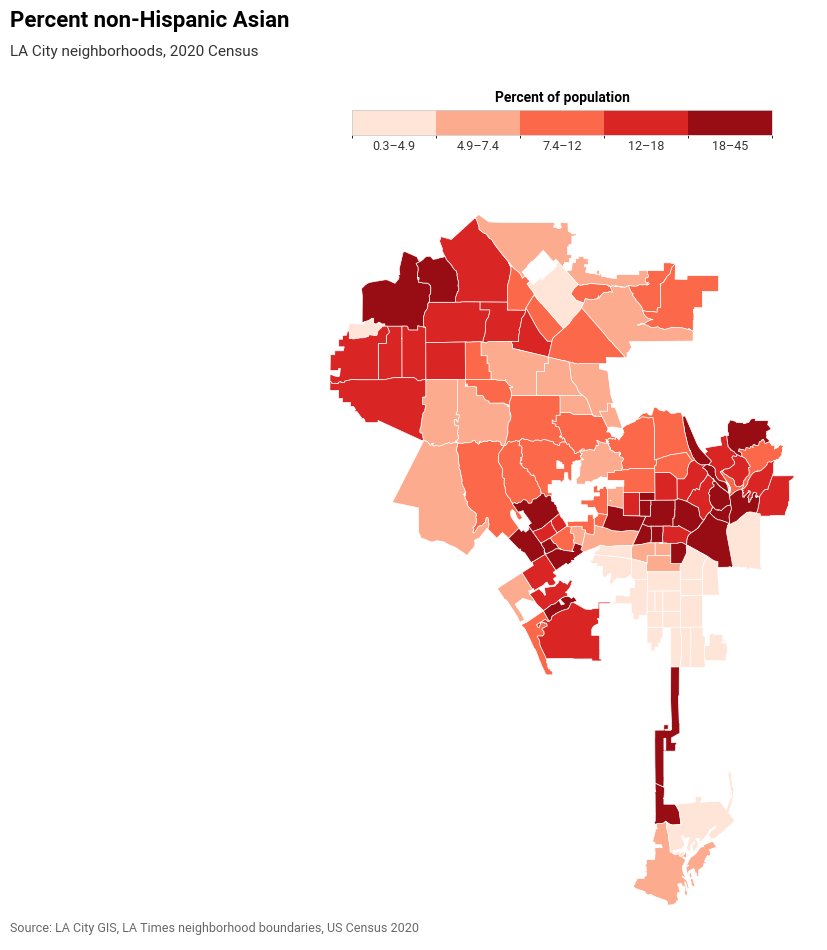

In [9]:
legend = LegendConfig(
    kind="binned",
    title="Percent of population",
    location="top",
    orientation="horizontal",
    scheme="quantiles",
    k=5,
)

layout = LayoutConfig(
    title="Percent non-Hispanic Asian",
    subtitle="LA City neighborhoods, 2020 Census",
    source="Source: LA City GIS, LA Times neighborhood boundaries, US Census 2020",
    figure_size=(12, 10),
    projection=3857,  # Web Mercator for LA
)

fig, ax = plot_choropleth(
    joined,
    value="pct_asian_nh",
    cmap="Reds",
    legend=legend,
    layout=layout,
    auto_project_data=True,
)

# Optionally save
# fig.savefig(OUT_DIR / 'la_neighborhoods_asian_pct.png', dpi=300, bbox_inches='tight')

## Map 2: Hispanic population with custom breaks

Using explicit break points for more control over the classification.


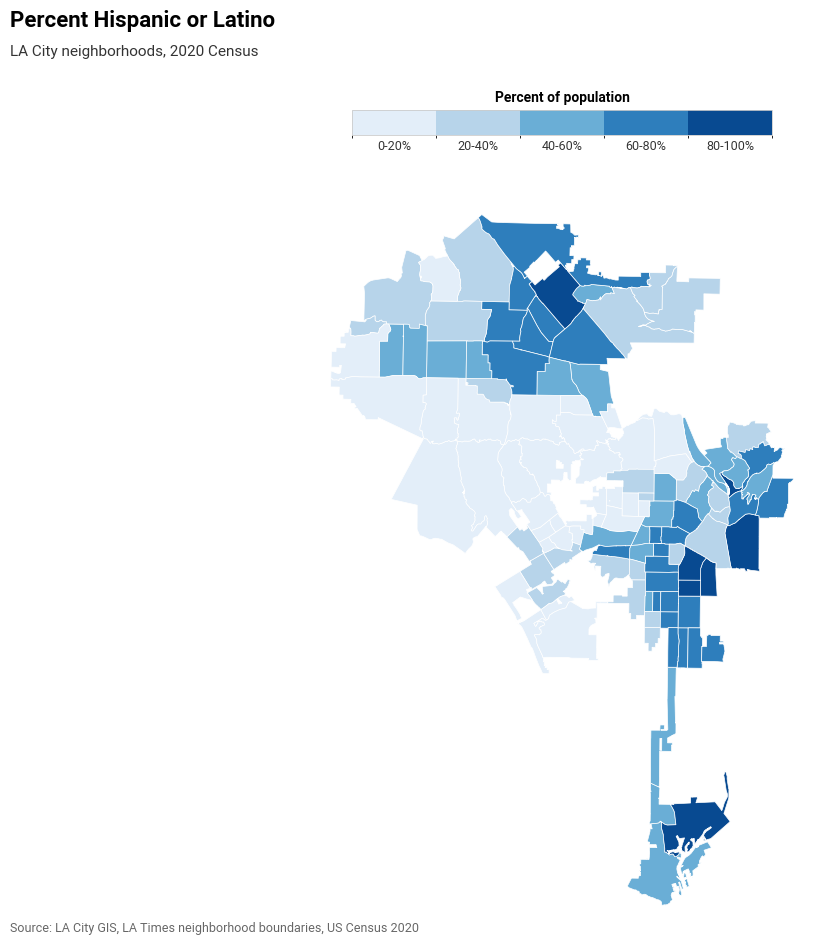

In [10]:
legend = LegendConfig(
    kind="binned",
    title="Percent of population",
    location="top",
    orientation="horizontal",
    breaks=[0, 20, 40, 60, 80, 100],
    labels=["0-20%", "20-40%", "40-60%", "60-80%", "80-100%"],
)

layout = LayoutConfig(
    title="Percent Hispanic or Latino",
    subtitle="LA City neighborhoods, 2020 Census",
    source="Source: LA City GIS, LA Times neighborhood boundaries, US Census 2020",
    figure_size=(12, 10),
)

fig, ax = plot_choropleth(
    joined,
    value="pct_hispanic",
    cmap="Blues",
    legend=legend,
    layout=layout,
    auto_project_data=True,
)


## Example 2: LAPD divisions

Larger administrative areas - useful for showing broader patterns.


In [11]:
# Load LAPD divisions with demographics
layer_name = 'lapd_divisions'

divisions = gpd.read_file(DATA_DIR / f'{layer_name}.geojson')
divisions_demo = pd.read_parquet(DATA_DIR / f'{layer_name}_demographics.parquet')

# Join on 'prec' (precinct number) - see config/layers.yml
divisions_joined = divisions.merge(divisions_demo, on='prec', how='left')

# Calculate percentages
divisions_joined['pct_white_nh'] = (divisions_joined['pop_white_nh'] / divisions_joined['pop_total'] * 100).round(1)
divisions_joined['pct_black_nh'] = (divisions_joined['pop_black_nh'] / divisions_joined['pop_total'] * 100).round(1)

print(f"Loaded {len(divisions_joined)} LAPD divisions")
# Show available columns that include division name and demographics
display_cols = ['prec', 'pop_total', 'pct_white_nh', 'pct_black_nh']
# Add name column if it exists
if 'aprec' in divisions_joined.columns:
    display_cols.insert(0, 'aprec')
elif 'name' in divisions_joined.columns:
    display_cols.insert(0, 'name')
    
divisions_joined[display_cols].head()


Loaded 21 LAPD divisions


,prec,pop_total,pct_white_nh,pct_black_nh
0,19,251569.0,10.5,2.7
1,17,230645.0,38.4,4.4
2,16,197309.0,26.3,2.8
3,21,210950.0,43.5,4.5
4,10,201376.0,44.2,4.0


## Map 3: Population density by LAPD division


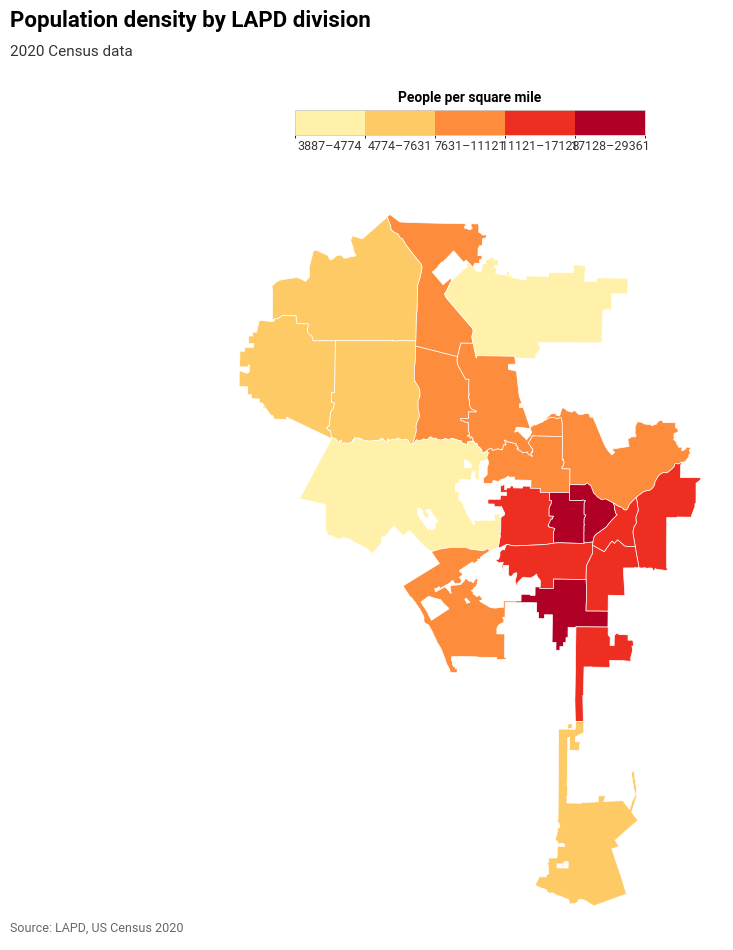

In [12]:
# Calculate population density (people per square mile)
# If area_sqmi doesn't exist, calculate it from geometry
if 'area_sqmi' not in divisions_joined.columns:
    # Convert to California Albers (EPSG:3310) for accurate area
    area_m2 = divisions_joined.to_crs(3310).geometry.area
    divisions_joined['area_sqmi'] = area_m2 / (1609.34 ** 2)  # Convert m² to mi²

divisions_joined['pop_density'] = (divisions_joined['pop_total'] / divisions_joined['area_sqmi']).round(0)

legend = LegendConfig(
    kind="binned",
    title="People per square mile",
    location="top",
    orientation="horizontal",
    scheme="natural",  # Jenks natural breaks
    k=5,
)

layout = LayoutConfig(
    title="Population density by LAPD division",
    subtitle="2020 Census data",
    source="Source: LAPD, US Census 2020",
    figure_size=(10, 10),
)

fig, ax = plot_choropleth(
    divisions_joined,
    value="pop_density",
    cmap="YlOrRd",
    legend=legend,
    layout=layout,
    auto_project_data=True,
)


## Example 3: LA County comprehensive neighborhoods

This is the most complete layer covering all of LA County - includes incorporated cities, unincorporated areas and LA City neighborhoods. 269 total features.


In [13]:
# Load comprehensive neighborhoods (entire LA County)
layer_name = 'la_neighborhoods_comprehensive'

comprehensive = gpd.read_file(DATA_DIR / f'{layer_name}.geojson')
comprehensive_demo = pd.read_parquet(DATA_DIR / f'{layer_name}_demographics.parquet')

# Join on 'slug' (URL-safe identifier)
comprehensive_joined = comprehensive.merge(comprehensive_demo, on='slug', how='left')

# Calculate percentages
comprehensive_joined['pct_asian_nh'] = (
    comprehensive_joined['pop_asian_nh'] / comprehensive_joined['pop_total'] * 100
).round(1)

print(f"Loaded {len(comprehensive_joined)} neighborhoods across LA County")

# Determine which name column to use
name_col = 'name' if 'name' in comprehensive_joined.columns else 'slug'

print(f"\nTop 10 areas by Asian population percentage:")
comprehensive_joined[[name_col, 'pop_total', 'pct_asian_nh']].nlargest(10, 'pct_asian_nh')


Loaded 270 neighborhoods across LA County

Top 10 areas by Asian population percentage:


,slug,pop_total,pct_asian_nh
132,walnut,28420.0,66.9
82,monterey-park,61047.0,66.1
3,arcadia,56677.0,64.6
96,rosemead,51151.0,63.9
150,temple-city,36425.0,63.6
100,san-gabriel,39647.0,63.4
19,cerritos,50105.0,61.8
140,rowland-heights,48262.0,61.3
142,san-marino,12520.0,60.5
111,diamond-bar,55053.0,59.2


## Map 4: Asian population across all of LA County


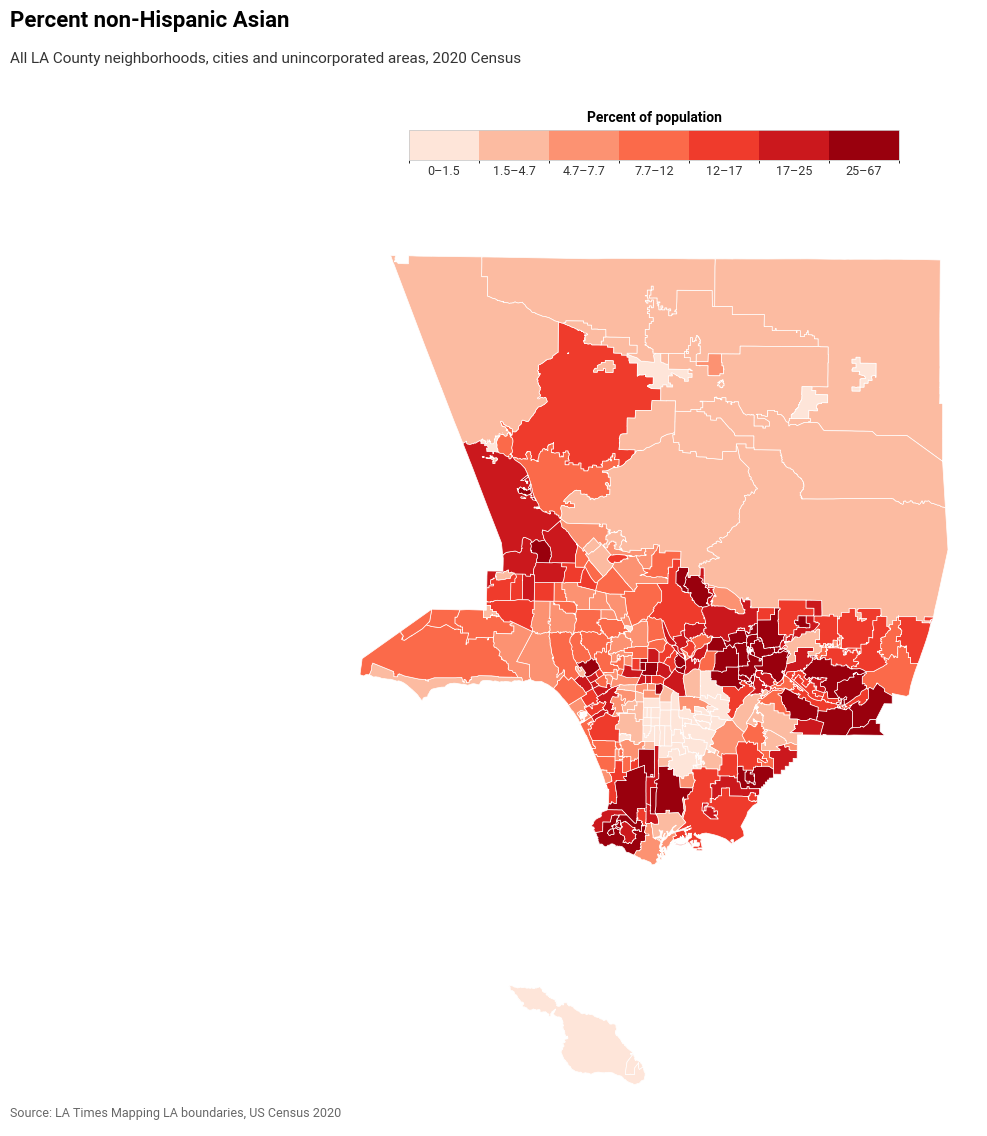

In [14]:
legend = LegendConfig(
    kind="binned",
    title="Percent of population",
    location="top",
    orientation="horizontal",
    palette=("Reds", 7),  # ColorBrewer 7-class Reds
    scheme="quantiles",
)

layout = LayoutConfig(
    title="Percent non-Hispanic Asian",
    subtitle="All LA County neighborhoods, cities and unincorporated areas, 2020 Census",
    source="Source: LA Times Mapping LA boundaries, US Census 2020",
    figure_size=(14, 12),
)

fig, ax = plot_choropleth(
    comprehensive_joined,
    value="pct_asian_nh",
    legend=legend,
    layout=layout,
    auto_project_data=True,
)


## Available layers with demographics

All polygon layers in `data/standard/` have matching `*_demographics.parquet` files:

**City boundaries:**
- `la_city_boundary` - City of LA boundary
- `la_city_neighborhoods` - LA City neighborhoods (114 neighborhoods)
- `la_city_neighborhood_councils` - Neighborhood councils (~99)
- `la_city_council_districts` - City council districts (15)
- `la_city_parks` - City parks (561)

**County boundaries:**
- `la_county_boundary` - LA County boundary
- `la_county_cities` - Cities and unincorporated areas (~88)
- `la_neighborhoods_comprehensive` - All neighborhoods, cities, unincorporated areas (269)
- `la_county_school_districts` - School districts (85)

**Public safety:**
- `lapd_bureaus` - LAPD bureaus (4)
- `lapd_divisions` - LAPD divisions (21)
- `lapd_reporting_districts` - LAPD reporting districts (~1,191)
- `lafd_station_boundaries` - LAFD station service areas (102)
- `lacofd_station_boundaries` - LA County Fire station areas (175)

See `config/layers.yml` for ID fields and more details.


## Demographic columns

All demographics files contain 2020 Census data:

**Population by race/ethnicity:**
- `pop_total` - Total population
- `pop_hispanic` - Hispanic or Latino
- `pop_not_hispanic` - Not Hispanic or Latino
- `pop_white_nh` - White alone (non-Hispanic)
- `pop_black_nh` - Black or African American (non-Hispanic)
- `pop_asian_nh` - Asian alone (non-Hispanic)
- `pop_aian_nh` - American Indian and Alaska Native (non-Hispanic)
- `pop_nhpi_nh` - Native Hawaiian and Pacific Islander (non-Hispanic)
- `pop_other_nh` - Some other race (non-Hispanic)
- `pop_two_or_more_nh` - Two or more races (non-Hispanic)

**Housing:**
- `housing_total` - Total housing units
- `housing_occupied` - Occupied units
- `housing_vacant` - Vacant units

**Metadata:**
- `source_blocks_count` - Number of Census blocks used in apportionment
- `apportioned_at` - Timestamp of apportionment
- `census_vintage` - Census year (2020)


## Tips for production maps

**Projections:**
- Use `projection=3857` (Web Mercator) for LA-area maps
- Use `projection=3310` (California Albers) for state-wide context
- Or let chorokit auto-project with `auto_project_data=True`

**Color schemes:**
- Sequential: `Reds`, `Blues`, `Greens`, `YlOrRd`, `PuBu`
- Use ColorBrewer palettes: `palette=("Reds", 7)` for 7-class scheme
- Keep it simple - 5-7 classes is usually best

**Classification:**
- `scheme="quantiles"` - equal number of features per class
- `scheme="natural"` - Jenks natural breaks (good for clustered data)
- `scheme="equal"` - equal intervals
- Or use explicit `breaks=[0, 20, 40, 60, 80, 100]` for full control

**Sources:**
- Always cite: "Source: [data provider], US Census 2020"
- Be specific about vintage and geography level

**Saving:**
```python
fig.savefig('map.png', dpi=300, bbox_inches='tight')
```
